ENGS 106 - Final Project
Authors - Taka Khoo, Doruk, Harry Leiter

<small>

    Overall design:

        typedef struct {
            image
            label
        } sample_t


        training(){
            init_network()
            sample = load_datapoint
            output = feedforward(sample->png)
            tocompare = getbackpropdata(sample)
            backprop(output, tocompare)
        }




        gettrainingdata(sample_t sample){
            Case (sample->label):
                1:
                    upscaledimg = upscale(sample->image)
                    gaussian = gaussian(upscaledimg)
                    harmonics = harmonics(gaussian, sample->fundamental_note_for_A_in_hertz)
                    harmonics_smear = gaussian(harmonics)
                    smooth = smooth(harmonics_smear)
                    return trainingcomparison       
                2:
                .
                .
                .
        
        }

</small>

# Below this markdown are an idea of the functions we could use to condition our data for the purposes of comparison during training

and here is my thinking behind these functions

<small> Create neural network Structure
    - inputs will be numbers 0-7 of mnist dataset (pictures of handwritten digits from 0-7)
        -These inputs will represent the notes of the major scale
    - output
        *Image of a spectrogram
            *Want to look like the input image? (maybe this would allow for more creative experimentation with finalized model than just looking like a letter)
            
            *Image is square, so we would want the output to be square as well
                -I'm not sure what to use for the image (spectrogram resolution):
                    Guessing around 1024x1024
                    
                    ~Training on 1024x1024 input images would probably be too resource intensive, so we might want to
                     upscale input image and then compare to that

                    *maybe drop down to 1008 for easier upscaling (mnist - 24x24 -- 24*36 = 1008 {24*4*3*3} -- esrgan upscaler works in factors of 1,2,3,4 )

            *We could compare the images with readily available tools online

            *In natural musical instruments, harmonics typically die out the further one gets from the fundamental note. Maybe we can
             achieve this by applying a horizontal gaussian filter to the output, and using that to determine loss as well
</small>

In [ ]:
%pip install numpy
%pip install scipy
%pip install matplotlib
%pip install torch
%pip install torchaudio
%pip install torchvision
%pip install numpy
%pip install Pillow
%pip install opencv-python
%pip install scikit-image
%pip install git+https://github.com/pvigier/perlin-numpy
%pip install IPython

Found existing installation: torch 2.6.0+cu118
Uninstalling torch-2.6.0+cu118:
  Successfully uninstalled torch-2.6.0+cu118
Found existing installation: torchvision 0.21.0+cu118
Uninstalling torchvision-0.21.0+cu118:
  Successfully uninstalled torchvision-0.21.0+cu118
Found existing installation: torchaudio 2.6.0+cu118
Uninstalling torchaudio-2.6.0+cu118:
  Successfully uninstalled torchaudio-2.6.0+cu118
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached torch-2.6.0-cp312-cp312-manylinux1_x86_64.whl.metadata (28 kB)
Using cached torch-2.6.0-cp312-cp312-manylinux1_x86_64.whl (766.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
basic

In [14]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter
from scipy.stats import norm
from PIL import Image
import matplotlib.pyplot as plt

* Upscaler:

In [15]:
import cv2

from scipy.signal import resample

def upscale(input):
    """
    Upscale the input image to 1008x1008 using SciPy's resample function.
    """
    img = cv2.imread(f"{input}.jpg", cv2.IMREAD_GRAYSCALE)
    # Resample rows first, then columns:
    upscaled_rows = resample(img, 1008, axis=0)
    upscaled = resample(upscaled_rows, 1008, axis=1)
    cv2.imwrite(f"{input}.png", upscaled)




* Gaussian function:

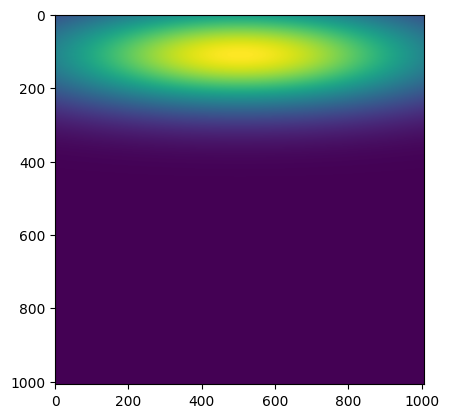

In [16]:
'''
                        1-D gaussian smearing
                        
'''
def gaussian1d(image, sigma, axis):

    blurred = gaussian_filter1d(image, sigma=sigma, axis=axis)
    return blurred
'''
                        2-D gaussian smearing
'''
def gaussian2d(image, sigma):
    image = gaussian_filter(image, sigma = sigma)
    return image
'''
                        Applies gaussian filter across entire image
                            * Doesnt smear, multiplies input by the filter directly
'''

def gaussianfilter(image, sigma, mu, fade):
      
    for row in range(image.shape[1]):
        #get pdf values for the row, multiply them by img
        image[row, :] = norm(loc = mu, scale = sigma).pdf(row) * image[row, :]
    for col in range(image.shape[1]):
        image[:, col] = norm(loc = 504, scale = fade).pdf(col) * image[:, col]
    return image

test = np.full((1008, 1008), 255).astype(np.float64)
test = gaussianfilter(test, 100, 110, 400)
test= test / test.max()
plt.imshow(test)
plt.show()

* Frequency Selector:

In [17]:
'''
                            This function selects only desired frequencies base on fundamental note

                            We could also use this function to extract whatever frequencies we want to keep at whatever time
'''
def get_fundamental_frequency(label):

    if (label == 18):
        freq = int(round(27.5 * 2 ** (11/12.0)))
    elif (label == 14):
        freq = int(round(27.5 * 2 ** (12/12.0)))
    else:
        freq = int(round(27.5 * 2 ** (label/12.0)))
    
    return freq

#Need to take care of S and E

def freq_selection(gaussian, fundamentalnote):
    only_selected = np.zeros((1008,1008))
    for column in range(1008):
        for row in range(1008):
            #Selection Conditions v
            if((row) % fundamentalnote == 0 or 
               (row) % (1.25 * fundamentalnote)  == 0 or 
               (row) % (1.5 * fundamentalnote) == 0 ):
                only_selected[row, column] = gaussian[row, column]
            else:
                only_selected[row, column] = 0
    return only_selected

* Perlin Noise:

6.044986340023871
255.0


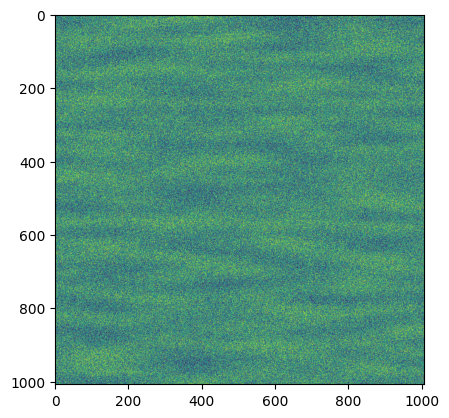

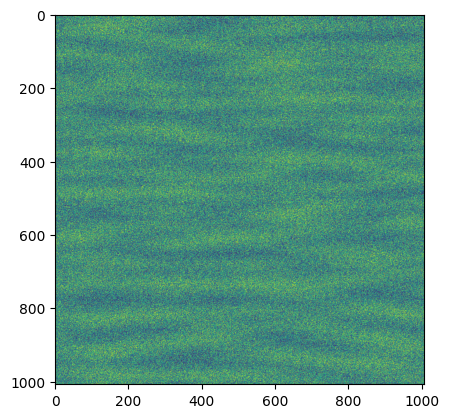

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from perlin_numpy import (generate_perlin_noise_2d, generate_fractal_noise_2d
)

def perlin_2d(input, noisex, noisey, fuzz, dilution):
    noise = generate_perlin_noise_2d(input.shape, (noisey, noisex))

    offset = np.full((1008, 1008), dilution).astype(np.float64) + (np.random.rand(1008, 1008))*fuzz
    
    noise = noise + offset

    noise = noise / noise.max()    

    input = input * noise

    return input

def perlin_2d_filter(shape_, scale, noisex, noisey, fuzz, dilution):
    noise = generate_perlin_noise_2d(shape_.shape, (noisey, noisex))

    offset = np.full((1008, 1008), dilution).astype(np.float64) + (np.random.rand(1008, 1008))*fuzz
    
    noise = noise + offset

    noise = (noise / noise.max()) * scale

    return noise

test = np.full((1008, 1008), 255).astype(np.float64)
filter = perlin_2d_filter(test, 1, 4, 24, 7, 1)
test = perlin_2d(test, 4, 24, 7, 1)
print(test.min())
print(test.max())
plt.imshow(test)
plt.show()
plt.imshow(filter)
plt.show()

Convert Spectrogram to wav:

In [19]:
import numpy as np
import cv2
from scipy.io.wavfile import write
from scipy.signal import resample

def convert_to_wav(spectrogram, output, duration): 
    spectrogram = spectrogram.astype(np.float32)

    sample_rate = 44100
    numsample = int(sample_rate * duration)
    spectrogram = resample(spectrogram, numsample, axis = 1)
    print(spectrogram.shape)
    height, width = spectrogram.shape

    #Create a time vector spanning the duration
    time = np.linspace(0, duration, width, endpoint=False)
    sinwaves = np.zeros((height, width)).astype(np.float32)

    #Looping over each row which is freq and each column which is time
    for row in range(height):
        offset = 0
        frequency = row + offset
        phase = np.abs(np.random.uniform(0, 2 * np.pi))
        amplitude_envelope = spectrogram[row, :]/255.0
        sinwaves[row, :] = amplitude_envelope * np.sin(2 * np.pi * frequency * time + phase)

    combined_signal = sinwaves.sum(axis = 0)
    resampled = resample(combined_signal, numsample)
    resampled /= np.max(np.abs(resampled))

    write(output, sample_rate, resampled.astype(np.float32))

In [20]:
#ripped from geeksforgeeks

import cv2
from skimage.metrics import structural_similarity as ssim
# Function to calculate SSIM
def calculate_ssim(imageA, imageB):
    # Convert images to grayscale
    grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)
    
    # Compute SSIM between the two images
    score, _ = ssim(grayA, grayB, full=True)
    return score

imageA = cv2.imread('thenumber4-out.png')
imageB = cv2.imread('thenumber5-out.png')

ssim_score = calculate_ssim(imageA, imageB)
print(f"SSIM score: {ssim_score}")

SSIM score: 0.8970872391475975


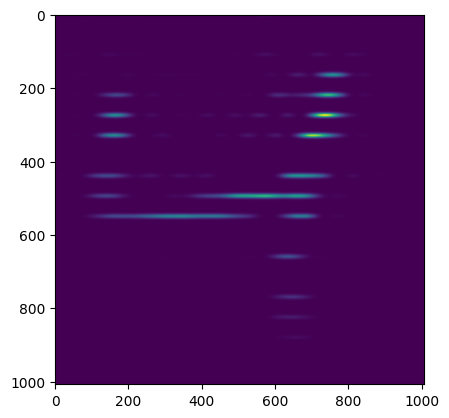

(1008, 44100)


IndexError: list index out of range

In [21]:
import cv2
'''
Main Processing Loop for Inputs
                                            Passing 4 and 5 through gaussian
'''

inputs = ['thenumber4']

#note to assign for inputs
fundamental_note = 110
#center of y-direction filter
mu = fundamental_note * 1
#y-direction filter sd
sigma = 300
#track fades in and out
fade_inout = 250
#smear x
smear_x = 10
#smear y
smear_y = 4
#x and y smoothing
smooth_xy = 1
#duration of track
duration = 1

##NOISE APPLIED TO OUTPUT
#Perlin noise constants for x and y
pnoisex = 12
pnoisey = 24
#Adds static fuzz to spectrogram
fuzz = 0
#Waters down perlin noise
dilution = 3

##NOISE OVERLAID
scale = 0 # Set 0 to disable
pnoisex2 = 1
pnoisey2 = 1
fuzz2 = 0
dilution2 = 40

 #Processing each input file
for i in inputs:
    upscale(f'{i}')

    #Gaussian Filter
    im2array = cv2.imread(f'{i}.png', cv2.IMREAD_GRAYSCALE).astype(np.float32)
    filtered = gaussianfilter(im2array, sigma, mu, fade_inout)
    curr = filtered

    #Harmonics etc
    harmonic = freq_selection(curr, fundamental_note)
    curr = harmonic

    #y-axis gaussian smear
    y_gaussian = gaussian1d(curr, smear_y, 0)
    curr = y_gaussian
    curr = (curr - curr.min()) / (curr.max() - curr.min()) * 255

    #x-axis gaussian smear
    x_gaussian = gaussian1d(curr, smear_x, 1)
    curr = x_gaussian
    curr = (curr - curr.min()) / (curr.max() - curr.min()) * 255

    #smoothing (2-D gaussian)
    smoothed = gaussian2d(curr, smooth_xy)
    curr = smoothed
    curr = (curr - curr.min()) / (curr.max() - curr.min()) * 255

    #perlin-noise
    perlin = perlin_2d(curr, pnoisex, pnoisey, fuzz, dilution)
    curr = perlin
    curr = (curr - curr.min()) / (curr.max() - curr.min()) * 255

    #noise overlay
    overlay = perlin_2d_filter(curr, scale, pnoisex2, pnoisey2, fuzz2, dilution2)
    curr = curr + overlay

    plt.imshow(curr)
    plt.show()

    #convert to wav file
    convert_to_wav(curr, f'{i}-out.wav', duration)

    #save image for comparison
    Image.fromarray(curr).convert('RGB').save(f'{i}-out.png')

#compare images
imageA = cv2.imread(f'{inputs[0]}-out.png')
imageB = cv2.imread(f'{inputs[1]}-out.png')

ssim_score = calculate_ssim(imageA, imageB)
print(f"SSIM score: {ssim_score}")
    


Network Design Notes

1. Input & Output

	Input X: 
		-Low Res image MNIST 
		-X ∈ R^(H_in x W_in x C)
		-H_in, W_in = height and widfth (28), C=1 for greyscale

	Output Y:
		-High Res Spectrogram that visually encodes desired harmonic stuff (fundamental, 1.25f, 1.5f)
		-Target Image size if 1008x1008
		-Y ∈ R^(H_out x W_out x 1)
		-Generated by processing functions (upscaling, Gaussian filtering, frequency selection, Perlin noise, etc.) that imprint the desired fundamental note and its harmonics (keeping only rows corresponding to f, 1.25f, 1.5f)

2. Mapping Digit to Musical Note

	0 → A
	1 → A#
	2 → B
	3 → C
	4 → C#
	5 → D
	6 → D#
	7 → E
	8 → F
	9 → F#
	S → G
	E → G#
	When generating the target spectrogram Y for a given sample, the processing pipeine uses a parameter (assigned fundamental frequency f0) in the frequency selection function. 
	That function sets pixel values only at rows corresponding to f0, 1.25f0, 1.5f0.
	Target Y embeds the harmonic structure of the note

3. Neural network Archistecture

	Encoder-Decoder (aka U-Net) Architecture
		-Encoder Learns a latent representation of the digit
		-Decoder upsamples and transforms that latent code into the desired spectrogram
	
	Encoder:
		Input: X ∈ R^(H_in x W_in x C)

		Convolution Layers: Apply several convolutional layers with nonlinear activations (ReLU?) to extract features.
			ex Layer: h1 = ReLU(W1 * X + b1)
			-W1 = set of learnable filters
			- * = convolution
			-b1 = bias

		Downsampling: Either using strided convolutions or pooling, reduce the spatial dimensions to form a latent representation z ∈ R^(H_z x W_z x D)
			-H_z, W_z << H_in, W_in
			-D = # of feature maps
	Decoder:
		Upsampling: Decoder used transposed convolutions (or upsampling folloed by convolution) to increase the spatial resolution of z until we reach H-out x W_out (1008x1008)
			Y' = ReLU(Wd *' bd)
			-*' = transposed convolution
		
		Skip Connections: To preserve spatial details, can use skip connections to copy features from encoder layers to corresponding decoder layers

		Output Layer: Final Layer outputs a single channel image using a convolution with a sigmoid or tanh activation to produce values in a desired range, either [0,1] or [-1,1]
	
	Math:
		Let f_θ denote the NN mapping, with parameters θ. 
			Forward Pass: Y_hat = f_θ(X), where Y_hat is the predicted spectrogram image

		**Loss Function: Still need to figure out structural way to do this, but for now, here is the pixel-wise MSE Loss way equation: 
		L(θ) = ||Y_hat - Y||^2

		Backpropagation: Using Gradient Descent (or Adam), we update the parameters:
			θ <- θ - η * ∇_θ * L(θ), where η = LR

4. Upscaler Component
	Very intense to train directly on 1008x1008 images, want to train network on a lower-res version/downscaled version of spectrogram
	We use a pre-trained ESRGAN upscaler to increase the resolution of the network output; this way we focus on the mapping itself first and then we can engance the resolution with the dedicated upscaler

Extra Math:
Convolution: For an input X and a filter W of size kxk, the convolution pixel (i,j) is
	(Y)ij = (Sum m=1->k)(Sum n=1 -> k)W_m,n * X_i+m-1, j+n-1 + b

Transposed Convolution: Inverse of Convolution, spreads each pixel of the latent representation into a arger region. Gradient of convolution w.r.t. its input

Loss Function (MSE):
	1/n * (Sum i=1 -> n) (Y_hat_i - Y-i)^2, where N = total # of pixels in output image

Gradient Descent Update:
	θ <- θ - η(Partial ∂L/∂θ)

Workflow Plan:

1. Data Prep: Use Processing functions to generate target spectrogram Y w/ fundamental note
2. NN Training: Input X is fed into encoder decoder network fθ to produce Y_hat, compute the loss, backpropogate the loss and update parameters with GD
3. Inference: At test time, given a new Digit X, the network outputs a spectrogram Y_hat, output is upscaled, 

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from torch.utils.data import Dataset

#Encoder/Decoder

class SpectrogramGenerator(nn.Module):
    def __init__(self):
        super(SpectrogramGenerator, self).__init__()

        # Encoder
        self.encode1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # Downsample to (64, 14, 14)
        )
        self.encode2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # Downsample to (128, 7, 7)
        )
        
        # Bottleneck to increase channels to 256
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Decoder with skip connections
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # (256,7,7)->(128,14,14)
        self.decode2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  # concat with encode2 output
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)   # (128,14,14)->(64,28,28)
        self.decode1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # concat with encode1 output
            nn.ReLU(inplace=True)
        )
        
        # Upsample to final size and output layer
        self.upsamplefinal = nn.Upsample(size=(1008, 1008), mode='bilinear', align_corners=False)
        self.finalconv = nn.Conv2d(64, 1, kernel_size=3, padding=1)
import torch
import torch.nn as nn

class SpectrogramGenerator(nn.Module):
    def __init__(self):
        super(SpectrogramGenerator, self).__init__()
        # Encoder Stage 1 (split)
        self.encode1_conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.encode1_pool = nn.MaxPool2d(2)  # (64, 28, 28) -> (64, 14, 14)
        
        # Encoder Stage 2 (split)
        self.encode2_conv = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.encode2_pool = nn.MaxPool2d(2)  # (128, 14, 14) -> (128, 7, 7)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Decoder with skip connections
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # (256,7,7) -> (128,14,14)
        self.decode2 = nn.Sequential(
            nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1),  # concat upsample_2 with encode2_conv
            nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)   # (128,14,14) -> (64,28,28)
        self.decode1 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1),  # concat upsample_1 with encode1_conv
            nn.ReLU(inplace=True)
        )
        
        # Final upsampling and output layer
        self.upsamplefinal = nn.Upsample(size=(1008, 1008), mode='bilinear', align_corners=False)
        self.finalconv = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        self.finalact = nn.LeakyReLU()

    def forward(self, x):
        # Encoder Stage 1
        encode1_conv = self.encode1_conv(x)           # (64, 28, 28)
        encode1 = self.encode1_pool(encode1_conv)       # (64, 14, 14)
        # Encoder Stage 2
        encode2_conv = self.encode2_conv(encode1)        # (128, 14, 14)
        encode2 = self.encode2_pool(encode2_conv)        # (128, 7, 7)
        # Bottleneck
        bottle_neck = self.bottleneck(encode2)           # (256, 7, 7)
        # Decoder stage 2 with skip from encode2_conv
        upsample_2 = self.upsample2(bottle_neck)         # (128, 14, 14)
        concat_2 = torch.cat([upsample_2, encode2_conv], dim=1)  # (256, 14, 14)
        decode_2 = self.decode2(concat_2)                # (128, 14, 14)
        # Decoder stage 1 with skip from encode1_conv
        upsample_1 = self.upsample1(decode_2)            # (64, 28, 28)
        concat_1 = torch.cat([upsample_1, encode1_conv], dim=1)  # (128, 28, 28)
        decode_1 = self.decode1(concat_1)                # (64, 28, 28)
        # Final upsampling and output
        upsampled = self.upsamplefinal(decode_1)         # (64, 1008, 1008)
        out = self.finalconv(upsampled)
        return self.finalact(out)

	
class SpectrogramDataset(Dataset):
	def __init__(self, root='./data', split="byclass", filter_labels=None, transform=None):
		self.transform = transforms.ToTensor()
		self.base_dataset = torchvision.datasets.EMNIST(
			root=root, train=True, split=split, download=True, transform=self.transform
		)
		self.filter_labels = filter_labels
		self.indices = [i for i, (_, label) in enumerate(self.base_dataset) if label in filter_labels]

	def __len__(self):
		return len(self.indices)

	def __getitem__(self, idx):
		actual_idx = self.indices[idx]
		img, label = self.base_dataset[actual_idx]
		img = img.transpose(1, 2)  # Transpose the image tensor
		# Convert image tensor to numpy array and scale to [0, 255]
		digit_img = img.squeeze().numpy() * 255
		# Generate the spectrogram target based on image and label
		target_np = generate_target_spectrogram(digit_img, float(label))
		# Normalize target to [0,1]
		target_np = (target_np - target_np.min()) / (target_np.max() - target_np.min() + 1e-8)
		target_tensor = torch.from_numpy(target_np).unsqueeze(0).float()
		return img, target_tensor
	

"""
We next need a target generation function, 
which will need to call the full processing pipeline with all of our 
functions we wrote earlier and based on the label

1. Save the input digit image numpy array with values 0-255 to disk as a temporary JPEG.
2. Call the upscaler function to upscale the image.
3. Load the upscaled image.
4. Apply a Gaussian filter (using gaussianfilter) to weight the image.
5. Apply frequency selection (freq_selection) using the fundamental note determined
by the digit label from exponential music equation f=110 * 2^(label/12)
6. Apply y-axis Gaussian smear (gaussian1d) then normalize.
7. Apply x-axis Gaussian smear (gaussian1d) then normalize.
8. Apply 2-D Gaussian smoothing (gaussian2d) then normalize.
9. Add Perlin noise using perlin_2d, normalize.
10. (Can Change, dont need, 0 if want disable) overlay additional noise via perlin_2d_filter.
11. Normalize the final output to the range 0-255 and return it.
"""
import os
import time
import tempfile
from PIL import Image
import cv2
import numpy as np

def generate_target_spectrogram(digit_image, label):
    # 1. Create a unique temporary file for the input image
    with tempfile.NamedTemporaryFile(suffix=".jpg", delete=False) as tmp:
        temp_jpg = tmp.name
    Image.fromarray(digit_image.astype(np.uint8)).convert('RGB').save(temp_jpg)
    
    # 2. Prepare a base name and corresponding output PNG name.
    base_name = os.path.splitext(temp_jpg)[0]  # remove extension
    temp_png = base_name + ".png"
    
    # 3. Call upscale using the unique base name (assumes upscale() uses base_name).
    upscale(base_name)
    
    # 4. Wait (up to 5 sec) for the output file to appear.
    timeout = 5.0
    start_time = time.time()
    while not os.path.exists(temp_png):
        time.sleep(0.1)
        if time.time() - start_time > timeout:
            raise TimeoutError(f"Upscale did not produce file {temp_png}")
    
    # 5. Read the upscaled image.
    upscaled = cv2.imread(temp_png, cv2.IMREAD_GRAYSCALE)
    if upscaled is None:
        raise ValueError(f"Failed to read upscaled image from {temp_png}")
    upscaled = upscaled.astype(np.float32)
    
    # 6. Continue with your processing...
    sigma_val = 400
    mu_val = 110
    fade_val = 250
    filtered = gaussianfilter(upscaled, sigma_val, mu_val, fade_val)
    
    fundamental_note = get_fundamental_frequency(label)
    harmonic = freq_selection(filtered, fundamental_note)
    
    smear_y = 2
    y_smeared = gaussian1d(harmonic, smear_y, 0)
    y_smeared = (y_smeared - y_smeared.min()) / (y_smeared.max() - y_smeared.min() + 1E-8) * 255
    
    smear_x = 20
    x_smeared = gaussian1d(y_smeared, smear_x, 1)
    x_smeared = (x_smeared - x_smeared.min()) / (x_smeared.max() - x_smeared.min() + 1E-8) * 255
    
    smooth_xy = 0
    smoothed = gaussian2d(x_smeared, smooth_xy)
    smoothed = (smoothed - smoothed.min()) / (smoothed.max() - smoothed.min() + 1E-8) * 255
    
    pnoisex = 24
    pnoisey = 24
    fuzz = 0
    dilution = 20
    perlin_img = perlin_2d(smoothed, pnoisex, pnoisey, fuzz, dilution)
    perlin_img = (perlin_img - perlin_img.min()) / (perlin_img.max() - perlin_img.min() + 1E-8) * 255
    
    scale_val = 0
    pnoisex2 = 2
    pnoisey2 = 24
    fuzz2 = 0
    dilution2 = 20
    overlay = perlin_2d_filter(perlin_img, scale_val, pnoisex2, pnoisey2, fuzz2, dilution2)
    final_img = perlin_img + overlay
    
    final_img = (final_img - final_img.min()) / (final_img.max() - final_img.min() + 1E-8)
    
    # 7. Clean up temporary files.
    os.remove(temp_jpg)
    os.remove(temp_png)
    
    return final_img

We will now execute the training loop, using MNIST as the dataset 

In [ ]:
from IPython.display import clear_output
import torch.cuda.amp as amp
import matplotlib.pyplot as plt

import torch.backends.cudnn as cudnn
cudnn.benchmark = True
cudnn.enabled = True

plt.ion()

scaler = torch.GradScaler()  # For AMP
step_count = 0
batchsize = 32
losses = []
loss_path = "losses.npy"

# Use the custom dataset instead of filtering EMNIST in the training loop.
filter_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 14}
train_dataset = SpectrogramDataset(root='./data', split="byclass", filter_labels=filter_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, 
                                           shuffle=True, num_workers=16)

model = SpectrogramGenerator()
criterion = nn.MSELoss(delta=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10


try:
		
	for epoch in range(num_epochs):
		running_loss = 0.0
		model.train()
		for batch_idx, (inputs, targets) in enumerate(train_loader):
			inputs = inputs.to(device)
			targets = targets.to(device)

			optimizer.zero_grad()
			with torch.autocast(device_type='cuda'):
				outputs = model(inputs)
				loss = criterion(outputs, targets)
			scaler.scale(loss).backward()
			scaler.step(optimizer)
			scaler.update()

			running_loss += loss.item() * inputs.size(0)
			step_count += inputs.size(0)

			if step_count % (batchsize * 5) == 0:
				clear_output(wait = True)
				fig, axs = plt.subplots(1, 3, figsize=(12, 4))
				axs[0].imshow(inputs[0].detach().cpu().squeeze().numpy(), cmap='gray')
				axs[0].set_title("Input")
				axs[1].imshow(targets[0].detach().cpu().squeeze().numpy(), cmap='gray')
				axs[1].set_title("Target")
				axs[2].imshow(outputs[0].detach().cpu().squeeze().numpy(), cmap='gray')
				axs[2].set_title("Output")
				plt.show()
				print(f"Step Count: {step_count}, Batch Loss: {loss.item():.4f}")
				

			if step_count % (batchsize * 313) == 0:
				checkpoint_path = f"U-Net_checkpoint_step_{step_count+1}.pth"
				torch.save(model.state_dict(), checkpoint_path)
				print(f"Model checkpoint saved to {checkpoint_path}")
				steps_loss = running_loss / ((batch_idx + 1) * batchsize) 
				losses.append(steps_loss)

except KeyboardInterrupt:
	#Save losses on exception
    np.save(loss_path, np.array(losses))

# Final save after completion
np.save(loss_path, np.array(losses))  
print(f"Final loss history saved to {loss_path}.")

plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss', color='blue')
plt.xlabel('Step Count (x10,016)')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

print("NN Training Complete!")



Finally, when we finish training, we can take a new digit img and pass it through the model and then convert the spectrogram to audio using the function we wrote

In [ ]:
# Ensure model is properly defined
model = SpectrogramGenerator()

# Load model weights
model.load_state_dict(torch.load("relul1loss_checkpoint_step_100801.pth", map_location=device))
model.to(device)
model.eval()


with torch.no_grad():
	sample_img, sample_label = train_dataset[0] #Getting our 1st sample from MNIST
	sample_img = sample_img.unsqueeze(0).to(device) #(1,1,28,28)
	predicted_spectrogram = model(sample_img) #(1,1, 1008, 1008)
	#COnverting to numpy arr + scaling
	predicted_spectrogram_np = (predicted_spectrogram.squeeze().cpu().numpy() - predicted_spectrogram.squeeze().cpu().numpy().min())/(predicted_spectrogram.squeeze().cpu().numpy() - predicted_spectrogram.squeeze().cpu().numpy().min())
	Image.fromarray(predicted_spectrogram_np.astype(np.uint8)).convert('RGB').save('predicted_spectrogram.png')
	convert_to_wav(predicted_spectrogram_np, 'predicted_audio.wav', duration=1)
	print("Inference complete. Predicted Spectrogram image and audio saved")

NameError: name 'SpectrogramGenerator' is not defined